In [1]:
import paho.mqtt.client as paho
import numpy as np
import random
import json
import networkx as nx
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
# %matplotlib inline

In [2]:
broker_ip = '192.168.0.104'
broker_ip = 'localhost'
# broker_ip = '10.1.199.251'
# broker_ip = '10.101.6.111'
connflag = False

In [3]:
def plot(G, title='step_1', ns=1000, fs=12, lim=2, figsize=(5, 5)):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}
    print('Total node number', N)

    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']


    fig = plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=fs)

    plt.title(title)
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    return plt, fig

In [9]:
mqttc = paho.Client()
counter = 0
N = 70
format_date = "%d %b %Y %H%M%S.%f"

def on_connect(client, userdata, flags, rc):
    global connflag
    #if connection is successful, rc value will be 0
    print("Connection returned result: " + str(rc) )
    connflag = True

def on_message(client, userdata, msg): 
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
def on_state(client, userdata, msg): 
    global G, counter
    counter += 1
    name = datetime.now().strftime(format_date)
    js = json.loads(msg.payload.decode())
    G.node[js['id']]['state'] = js['state']
    if counter%N == 0:
        plt, fig = plot(G, 'step {}'.format((counter-1)//N), **plt_set)
        fig.savefig('figures/{}.png'.format(name))
        plt.close()
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    print( log)
    with open("log.txt", "a") as myfile:
        myfile.write("{},{}\n".format(name, log))
        
def on_finish(client, userdata, msg):  # on finish step
    global node_set
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    node_id = msg.payload.decode()
    node_set.remove(node_id)
    name = datetime.now().strftime(format_date)
    with open("log_node_set.txt", "a") as myfile:
        myfile.write("{},{}\n".format(name, node_set))
    if len(node_set) == 0:
        mqttc.publish('next', 'dummy_msg', qos=2)
        node_set = {str(x) for x in range(N)}
    
    
node_set = {str(x) for x in range(N)}
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.message_callback_add("state", on_state)
mqttc.message_callback_add("finish", on_finish)

mqttc.connect(broker_ip)
mqttc.loop_start()
mqttc.subscribe('state', 2)
mqttc.subscribe('finish', 2)

Connection returned result: 0


(0, 2)

(11.252796420940387, 11.252796420940387) (1, 0)
Total node number 70


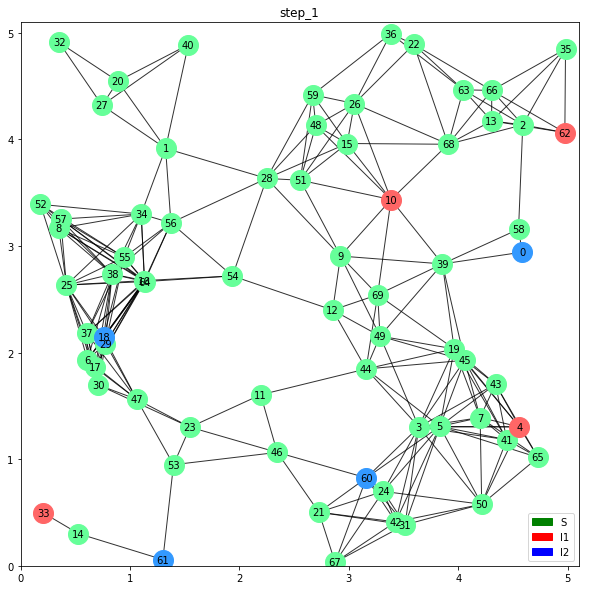

In [10]:
paramet = {
        'alpha': [0.5, 0.5], # infect rate 
        'mu': [0.5, 0.5], # sleep s 
        'gamma': [0.1, 0.1], # rec rate 
        'lambda': [0.7, 0.2], # sleep I1 
        'kappa': [0.7, 0.2] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
np.random.seed(314)  # structure
random.seed(6)       # infected
# N = 5
r = 1
number_subgraphs = 0

while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=4, I2_a=4, grid_size=[5,5], create=True) # net='Uniform Grid'
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

G = a.G
# G.node[0]['state'] = 'S_s'

plt_set = {
    'ns': 400, 
    'fs': 10,
    'lim': 5.1, 
    'figsize': (10,10)
}
plt, fig = plot(G, **plt_set) #  ns=300, fs=6,lim=5
# plt.show()
fig.savefig('figures/_.png')

In [11]:
G.node[1]

msg_list = []
for node_id in range(N):
    neighbours = list(G[node_id])
    msg = {
        "id": node_id,
        "state": G.node[node_id]['state'],
        "neighbours": neighbours
    }
    msg_list.append(msg)
    print(msg)
    
mqttc.publish('init', json.dumps(msg_list))

{'id': 0, 'state': 'I2_a', 'neighbours': [39, 58]}
{'id': 1, 'state': 'S_a', 'neighbours': [20, 27, 28, 34, 40, 56]}
{'id': 2, 'state': 'S_a', 'neighbours': [13, 35, 58, 62, 63, 66, 68]}
{'id': 3, 'state': 'S_a', 'neighbours': [4, 5, 7, 19, 24, 31, 41, 42, 43, 44, 45, 49, 50, 60]}
{'id': 4, 'state': 'I1_a', 'neighbours': [3, 5, 7, 19, 41, 43, 45, 50, 65]}
{'id': 5, 'state': 'S_a', 'neighbours': [3, 4, 7, 19, 24, 31, 41, 42, 43, 44, 45, 50, 60, 65]}
{'id': 6, 'state': 'S_a', 'neighbours': [16, 17, 18, 25, 29, 30, 37, 38, 47, 64]}
{'id': 7, 'state': 'S_a', 'neighbours': [3, 4, 5, 19, 41, 43, 45, 50, 65]}
{'id': 8, 'state': 'S_a', 'neighbours': [16, 25, 34, 38, 52, 55, 57, 64]}
{'id': 9, 'state': 'S_a', 'neighbours': [10, 12, 28, 39, 49, 51, 69]}
{'id': 10, 'state': 'I1_a', 'neighbours': [9, 15, 26, 39, 48, 51, 68, 69]}
{'id': 11, 'state': 'S_a', 'neighbours': [23, 44, 46]}
{'id': 12, 'state': 'S_a', 'neighbours': [9, 44, 49, 54, 69]}
{'id': 13, 'state': 'S_a', 'neighbours': [2, 35, 62, 6

In [ ]:
# node_set = {str(x) for x in range(5)}
mqttc.publish('finish', '14', qos=2)
node_set


In [ ]:
mqttc.loop_stop()

In [ ]:
mqttc.publish('next', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('stop', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('kill', 'process die', qos=2)

In [ ]:
mqttc.publish('paramet', json.dumps(paramet), qos=2)

In [12]:
mqttc.publish('start', 'dummy_msg', qos=2)

-t finish | -p 18
-t state | -p {"step": 0, "state": "S_a", "id": 64}
-t state | -p {"step": 0, "state": "S_a", "id": 65}
-t state | -p {"step": 0, "state": "S_a", "id": 66}
-t state | -p {"step": 0, "state": "S_a", "id": 67}
-t state | -p {"step": 0, "state": "S_a", "id": 68}
-t state | -p {"step": 0, "state": "S_a", "id": 69}
-t state | -p {"step": 0, "state": "S_a", "id": 31}
-t state | -p {"step": 0, "state": "S_a", "id": 32}
-t state | -p {"step": 0, "state": "I1_a", "id": 33}
-t state | -p {"step": 0, "state": "S_a", "id": 34}
-t state | -p {"step": 0, "state": "S_a", "id": 35}
-t state | -p {"step": 0, "state": "S_a", "id": 36}
-t state | -p {"step": 0, "state": "S_a", "id": 37}
-t state | -p {"step": 0, "state": "S_a", "id": 38}
-t state | -p {"step": 0, "state": "S_a", "id": 39}
-t state | -p {"step": 0, "state": "S_a", "id": 40}
-t state | -p {"step": 0, "state": "S_a", "id": 41}
-t state | -p {"step": 0, "state": "S_a", "id": 42}
-t state | -p {"step": 0, "state": "S_a", "id

-t state | -p {"step": 1, "state": "S_a", "id": 63}
-t finish | -p 34
-t finish | -p 55
-t finish | -p 56
-t finish | -p 57
-t finish | -p 4
-t finish | -p 5
-t finish | -p 20
-t finish | -p 2
-t finish | -p 13
-t finish | -p 22
-t finish | -p 24
-t finish | -p 3
-t finish | -p 7
-t finish | -p 19
-t finish | -p 54
-t finish | -p 16
-t finish | -p 25
-t finish | -p 10
-t finish | -p 26
-t finish | -p 9
-t finish | -p 15
-t finish | -p 12
-t finish | -p 21
-t finish | -p 28
-t finish | -p 30
-t finish | -p 1
-t finish | -p 27
-t finish | -p 14
-t finish | -p 23
-t finish | -p 0
-t finish | -p 11
-t finish | -p 39
-t finish | -p 58
-t finish | -p 41
-t finish | -p 50
-t finish | -p 40
-t finish | -p 66
-t finish | -p 35
-t finish | -p 68
-t finish | -p 63
-t finish | -p 62
-t finish | -p 44
-t finish | -p 49
-t finish | -p 60
-t finish | -p 31
-t finish | -p 42
-t finish | -p 43
-t finish | -p 65
-t finish | -p 45
-t finish | -p 47
-t finish | -p 37
-t finish | -p 38
-t finish | -p 52
-t

-t state | -p {"state": "S_s", "id": 30, "step": 3}
-t finish | -p 0
-t finish | -p 20
-t finish | -p 68
-t finish | -p 35
-t finish | -p 62
-t finish | -p 63
-t finish | -p 31
-t finish | -p 42
-t finish | -p 60
-t finish | -p 66
-t finish | -p 39
-t finish | -p 44
-t finish | -p 67
-t finish | -p 56
-t finish | -p 57
-t finish | -p 52
-t finish | -p 47
-t finish | -p 64
-t finish | -p 69
-t finish | -p 45
-t finish | -p 49
-t finish | -p 58
-t finish | -p 50
-t finish | -p 40
-t finish | -p 65
-t finish | -p 41
-t finish | -p 53
-t finish | -p 51
-t finish | -p 48
-t finish | -p 59
-t finish | -p 46
-t finish | -p 61
-t finish | -p 36
-t finish | -p 33
-t finish | -p 3
-t finish | -p 28
-t finish | -p 11
-t finish | -p 32
-t finish | -p 23
-t state | -p {"state": "I2_s", "id": 0, "step": 4}
-t finish | -p 39
-t finish | -p 58
-t state | -p {"state": "S_a", "id": 1, "step": 4}
-t state | -p {"state": "I1_a", "id": 2, "step": 4}
-t state | -p {"state": "S_a", "id": 3, "step": 4}
-t sta

-t state | -p {"state": "S_s", "id": 30, "step": 5}
-t finish | -p 43
-t finish | -p 50
-t finish | -p 27
-t finish | -p 28
-t finish | -p 19
-t finish | -p 24
-t finish | -p 41
-t finish | -p 10
-t finish | -p 15
-t finish | -p 26
-t finish | -p 3
-t finish | -p 9
-t finish | -p 12
-t finish | -p 20
-t finish | -p 14
-t finish | -p 1
-t finish | -p 8
-t finish | -p 30
-t finish | -p 17
-t finish | -p 18
-t finish | -p 29
-t finish | -p 0
-t finish | -p 11
-t finish | -p 23
-t finish | -p 68
-t finish | -p 35
-t finish | -p 62
-t finish | -p 63
-t finish | -p 31
-t finish | -p 42
-t finish | -p 60
-t finish | -p 39
-t finish | -p 58
-t finish | -p 40
-t finish | -p 34
-t finish | -p 66
-t finish | -p 45
-t finish | -p 49
-t finish | -p 44
-t finish | -p 65
-t finish | -p 64
-t finish | -p 57
-t finish | -p 55
-t finish | -p 52
-t finish | -p 59
-t finish | -p 37
-t finish | -p 69
-t finish | -p 67
-t finish | -p 47
-t finish | -p 53
-t finish | -p 51
-t finish | -p 48
-t finish | -p 33

-t state | -p {"step": 7, "state": "I1_a", "id": 63}
-t finish | -p 19
-t finish | -p 3
-t finish | -p 9
-t finish | -p 12
-t finish | -p 18
-t finish | -p 29
-t finish | -p 39
-t finish | -p 50
-t finish | -p 68
-t finish | -p 62
-t finish | -p 63
-t finish | -p 35
-t finish | -p 31
-t finish | -p 60
-t finish | -p 56
-t finish | -p 34
-t finish | -p 40
-t finish | -p 21
-t finish | -p 16
-t finish | -p 25
-t finish | -p 28
-t finish | -p 20
-t finish | -p 27
-t finish | -p 14
-t finish | -p 8
-t finish | -p 23
-t finish | -p 30
-t finish | -p 6
-t finish | -p 0
-t finish | -p 1
-t finish | -p 11
-t finish | -p 44
-t finish | -p 45
-t finish | -p 49
-t finish | -p 42
-t finish | -p 65
-t finish | -p 66
-t finish | -p 67
-t finish | -p 37
-t finish | -p 52
-t finish | -p 55
-t finish | -p 69
-t finish | -p 51
-t finish | -p 48
-t finish | -p 64
-t finish | -p 46
-t finish | -p 33
-t finish | -p 61
-t finish | -p 59
-t finish | -p 47
-t finish | -p 32
-t finish | -p 36
-t finish | -p 53

-t state | -p {"state": "S_a", "id": 30, "step": 9}
-t finish | -p 27
-t finish | -p 14
-t finish | -p 41
-t finish | -p 43
-t finish | -p 50
-t finish | -p 8
-t finish | -p 6
-t finish | -p 25
-t finish | -p 18
-t finish | -p 68
-t finish | -p 35
-t finish | -p 62
-t finish | -p 63
-t finish | -p 31
-t finish | -p 42
-t finish | -p 60
-t finish | -p 66
-t finish | -p 39
-t finish | -p 44
-t finish | -p 49
-t finish | -p 64
-t finish | -p 52
-t finish | -p 59
-t finish | -p 38
-t finish | -p 37
-t finish | -p 69
-t finish | -p 45
-t finish | -p 58
-t finish | -p 65
-t finish | -p 67
-t finish | -p 53
-t finish | -p 51
-t finish | -p 48
-t finish | -p 61
-t finish | -p 40
-t finish | -p 36
-t finish | -p 46
-t finish | -p 47
-t finish | -p 33
-t finish | -p 0
-t finish | -p 1
-t finish | -p 20
-t finish | -p 11
-t finish | -p 23
-t finish | -p 30
-t finish | -p 28
-t finish | -p 32
-t finish | -p 17
-t finish | -p 25
-t state | -p {"step": 10, "state": "S_a", "id": 64}
-t state | -p {"s

-t state | -p {"step": 11, "state": "I1_s", "id": 63}
-t finish | -p 27
-t finish | -p 28
-t finish | -p 8
-t finish | -p 16
-t finish | -p 17
-t finish | -p 18
-t finish | -p 13
-t finish | -p 4
-t finish | -p 5
-t finish | -p 7
-t finish | -p 19
-t finish | -p 2
-t finish | -p 3
-t finish | -p 24
-t finish | -p 30
-t finish | -p 29
-t finish | -p 25
-t finish | -p 10
-t finish | -p 12
-t finish | -p 9
-t finish | -p 26
-t finish | -p 15
-t finish | -p 22
-t finish | -p 21
-t finish | -p 20
-t finish | -p 14
-t finish | -p 6
-t finish | -p 34
-t finish | -p 1
-t finish | -p 40
-t finish | -p 66
-t finish | -p 68
-t finish | -p 35
-t finish | -p 62
-t finish | -p 63
-t finish | -p 38
-t finish | -p 55
-t finish | -p 57
-t finish | -p 54
-t finish | -p 56
-t finish | -p 31
-t finish | -p 41
-t finish | -p 42
-t finish | -p 43
-t finish | -p 44
-t finish | -p 45
-t finish | -p 49
-t finish | -p 23
-t finish | -p 0
-t finish | -p 11
-t finish | -p 50
-t finish | -p 60
-t finish | -p 65
-t

-t state | -p {"step": 13, "state": "S_s", "id": 38}
-t state | -p {"step": 13, "state": "I2_a", "id": 39}
-t state | -p {"step": 13, "state": "S_s", "id": 40}
-t state | -p {"step": 13, "state": "I1_a", "id": 41}
-t state | -p {"step": 13, "state": "I1_a", "id": 42}
-t state | -p {"step": 13, "state": "I1_a", "id": 43}
-t state | -p {"step": 13, "state": "S_s", "id": 44}
-t state | -p {"step": 13, "state": "I1_a", "id": 45}
-t state | -p {"step": 13, "state": "I1_a", "id": 46}
-t state | -p {"step": 13, "state": "S_s", "id": 47}
-t state | -p {"step": 13, "state": "I1_s", "id": 48}
-t state | -p {"step": 13, "state": "S_s", "id": 49}
-t state | -p {"step": 13, "state": "I1_a", "id": 50}
-t state | -p {"step": 13, "state": "I1_s", "id": 51}
-t state | -p {"step": 13, "state": "S_a", "id": 52}
-t state | -p {"step": 13, "state": "I1_s", "id": 53}
-t state | -p {"step": 13, "state": "S_s", "id": 54}
-t state | -p {"step": 13, "state": "S_s", "id": 55}
-t state | -p {"step": 13, "state": 

-t state | -p {"step": 15, "state": "I1_s", "id": 63}
-t finish | -p 27
-t finish | -p 28
-t finish | -p 40
-t finish | -p 17
-t finish | -p 18
-t finish | -p 25
-t finish | -p 13
-t finish | -p 4
-t finish | -p 7
-t finish | -p 19
-t finish | -p 24
-t finish | -p 5
-t finish | -p 2
-t finish | -p 22
-t finish | -p 3
-t finish | -p 10
-t finish | -p 15
-t finish | -p 26
-t finish | -p 30
-t finish | -p 29
-t finish | -p 16
-t finish | -p 9
-t finish | -p 12
-t finish | -p 21
-t finish | -p 20
-t finish | -p 14
-t finish | -p 1
-t finish | -p 8
-t finish | -p 23
-t finish | -p 6
-t finish | -p 11
-t finish | -p 0
-t finish | -p 66
-t finish | -p 68
-t finish | -p 35
-t finish | -p 62
-t finish | -p 63
-t finish | -p 37
-t finish | -p 38
-t finish | -p 54
-t finish | -p 55
-t finish | -p 57
-t finish | -p 56
-t finish | -p 34
-t finish | -p 41
-t finish | -p 43
-t finish | -p 50
-t finish | -p 31
-t finish | -p 44
-t finish | -p 45
-t finish | -p 49
-t finish | -p 42
-t finish | -p 60
-t

-t state | -p {"state": "S_a", "id": 30, "step": 17}
-t finish | -p 34
-t finish | -p 37
-t finish | -p 38
-t finish | -p 54
-t finish | -p 55
-t finish | -p 4
-t finish | -p 5
-t finish | -p 7
-t finish | -p 27
-t finish | -p 28
-t finish | -p 13
-t finish | -p 19
-t finish | -p 24
-t finish | -p 3
-t finish | -p 2
-t finish | -p 22
-t finish | -p 21
-t finish | -p 10
-t finish | -p 15
-t finish | -p 26
-t finish | -p 9
-t finish | -p 12
-t finish | -p 20
-t finish | -p 14
-t finish | -p 8
-t finish | -p 6
-t finish | -p 25
-t finish | -p 29
-t finish | -p 30
-t finish | -p 0
-t finish | -p 1
-t finish | -p 11
-t finish | -p 23
-t finish | -p 39
-t finish | -p 58
-t finish | -p 40
-t finish | -p 56
-t finish | -p 66
-t finish | -p 68
-t finish | -p 62
-t finish | -p 63
-t finish | -p 35
-t finish | -p 31
-t finish | -p 41
-t finish | -p 42
-t finish | -p 43
-t finish | -p 44
-t finish | -p 45
-t finish | -p 60
-t finish | -p 49
-t finish | -p 50
-t finish | -p 65
-t finish | -p 67
-t 

-t finish | -p 28
-t state | -p {"step": 19, "state": "I1_a", "id": 43}
-t finish | -p 16
-t finish | -p 18
-t state | -p {"step": 19, "state": "I1_a", "id": 44}
-t state | -p {"step": 19, "state": "I1_a", "id": 45}
-t state | -p {"step": 19, "state": "S_a", "id": 46}
-t state | -p {"step": 19, "state": "S_s", "id": 47}
-t state | -p {"step": 19, "state": "I1_a", "id": 48}
-t state | -p {"step": 19, "state": "I1_a", "id": 49}
-t state | -p {"step": 19, "state": "S_a", "id": 50}
-t state | -p {"step": 19, "state": "I1_s", "id": 51}
-t state | -p {"step": 19, "state": "S_s", "id": 52}
-t state | -p {"step": 19, "state": "I1_a", "id": 53}
-t state | -p {"step": 19, "state": "S_s", "id": 54}
-t state | -p {"step": 19, "state": "S_a", "id": 55}
-t state | -p {"step": 19, "state": "S_s", "id": 56}
-t state | -p {"step": 19, "state": "S_s", "id": 57}
-t state | -p {"step": 19, "state": "S_a", "id": 58}
-t state | -p {"step": 19, "state": "I1_a", "id": 59}
-t state | -p {"step": 19, "state": "

-t state | -p {"step": 21, "state": "I1_a", "id": 63}
-t finish | -p 13
-t finish | -p 6
-t finish | -p 18
-t finish | -p 25
-t finish | -p 29
-t finish | -p 4
-t finish | -p 5
-t finish | -p 19
-t finish | -p 24
-t finish | -p 7
-t finish | -p 2
-t finish | -p 22
-t finish | -p 3
-t finish | -p 21
-t finish | -p 10
-t finish | -p 15
-t finish | -p 30
-t finish | -p 17
-t finish | -p 16
-t finish | -p 9
-t finish | -p 26
-t finish | -p 23
-t finish | -p 8
-t finish | -p 1
-t finish | -p 27
-t finish | -p 11
-t finish | -p 14
-t finish | -p 0
-t finish | -p 66
-t finish | -p 68
-t finish | -p 35
-t finish | -p 62
-t finish | -p 63
-t finish | -p 54
-t finish | -p 57
-t finish | -p 31
-t finish | -p 41
-t finish | -p 42
-t finish | -p 43
-t finish | -p 44
-t finish | -p 45
-t finish | -p 49
-t finish | -p 50
-t finish | -p 60
-t finish | -p 64
-t finish | -p 47
-t finish | -p 37
-t finish | -p 38
-t finish | -p 55
-t finish | -p 52
-t finish | -p 69
-t finish | -p 33
-t finish | -p 61
-t

In [17]:
# mqttc.reinitialise()
# mqttc.loop_start()
msg = {
                'step': 22, 
                'pi_id': 27,  # 27
                'state': 'S_a'
            }
mqttc.publish('27', json.dumps(msg), 2) 

In [ ]:
# a = ['python node_{0}/pi_main_2.py node_{0}'.format(i) for i in range(0, 5)]
# str.join(' & ', a)

# with open('node_id.json') as f:
#     my_id_list = json.load(f)

# my_nodes = {node_id: node_id**2 for node_id in my_id_list}
node_list = list(range(5, 10))
node_list
